# FENE beadspring with variable kuhn length experiment data analysis

In [42]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Read and process data

In [75]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/13-EEA1_short+Rab5_10x-long_time/7ded95ff"
NAME_EC = "13-EEA1_short+Rab5_10x-long_time.toml"
CONTINUE = False
CONTINUE_t_equilibrium = 45000000
N_WORKERS = 8

In [ ]:
pandarallel.initialize(
    nb_workers=N_WORKERS,
    progress_bar=False,
    use_memory_fs=False
)

In [76]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC

### Read experiment config

In [77]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'm_end': 1.5, 'd_end_start': 15, 'd_end_delta': 0.0, 'd_end_n_values': 1, 'n_relax_steps': 20000000, 'n_equilibrium_steps': 500000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_nod

In [78]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[190.2]

In [79]:
d_ends: list[float] = [
    conf.simulation_config.variables["d_end_start"] + conf.simulation_config.variables["d_end_delta"] * i
    for i in range(conf.simulation_config.variables["d_end_n_values"])
]
d_ends

[15.0]

### Read initial system

In [80]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,-0.159927,-0.017451,-0.956566,0,0,0
3,1,2,-0.319854,-0.034901,-1.913132,0,0,0
4,1,2,-0.479782,-0.052352,-2.869698,0,0,0
5,1,2,-0.639709,-0.069802,-3.826265,0,0,0
...,...,...,...,...,...,...,...,...
3196,50,2,40.405722,-3.471380,40.380689,0,0,0
3197,50,2,41.090565,-3.530217,41.065107,0,0,0
3198,50,2,41.775408,-3.589054,41.749526,0,0,0
3199,50,2,42.460251,-3.647891,42.433944,0,0,0


In [81]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
3146,1,3195,3196
3147,1,3196,3197
3148,1,3197,3198
3149,1,3198,3199


In [82]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
3096,1,3194,3195,3196
3097,1,3195,3196,3197
3098,1,3196,3197,3198
3099,1,3197,3198,3199


In [83]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Extract main-axis dataframe

In [84]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED.mkdir(exist_ok=True, parents=True)

In [85]:
PATH_DF_MAIN_AXIS = PATH_DATA_PROCESSED / "main_axis.csv"

In [86]:
if PATH_DF_MAIN_AXIS.exists():
    df_main_axis = pd.read_csv(PATH_DF_MAIN_AXIS)
else:
    df_main_axis = transform.unfold_coordinates_df(system.atoms, system).groupby("molecule-ID").head(n=2)
    df_main_axis.to_csv(PATH_DF_MAIN_AXIS, index=False)
df_main_axis

,molecule-ID,type,x,y,z,ix,iy,iz
0,1,1,0.000000,0.000000,0.000000,0,0,0
1,1,1,-0.159927,-0.017451,-0.956566,0,0,0
2,2,1,0.000000,0.000000,0.000000,0,0,0
3,2,1,-0.483684,-0.375608,0.752242,0,0,0
4,3,1,0.000000,0.000000,0.000000,0,0,0
...,...,...,...,...,...,...,...,...
95,48,1,-0.045480,0.123187,-0.961071,0,0,0
96,49,1,0.000000,0.000000,0.000000,0,0,0
97,49,1,-0.113589,0.924755,-0.269864,0,0,0
98,50,1,0.000000,0.000000,0.000000,0,0,0


### Read and process trajectories

In [26]:
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectory_unfolded_kappas_d_ends.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K-vary-d_end/test-5-FENE-beadspring-vary-l_K-vary-d_end/e296c212/data/processed/trajectory_unfolded_kappas_d_ends.csv')

In [27]:
def read_and_process_kappas_d_ends_df(experiment_path: pathlib.Path, kappas: list[float], d_ends: list[float]):
    dfs = []
    for i in range(1, len(kappas) + 1):
        for j in range(1, len(d_ends) + 1):
            paths_trajectories = [
                experiment_path / "data" / "raw" / f"i_kappa={i}" / f"j_d_end={j}" / f"polymer_relax-{i}-{j}.out",
                experiment_path / "data" / "raw" / f"i_kappa={i}" / f"j_d_end={j}" / f"polymer-{i}-{j}.out"
            ]

            if CONTINUE:
                paths_trajectories = [
                    experiment_path / "data" / "raw" / f"i_kappa={i}" / f"j_d_end={j}" / f"polymer_relax-{i}-continue.out",
                    experiment_path / "data" / "raw" /  f"i_kappa={i}" / f"j_d_end={j}" / f"polymer-{i}-continue.out"
                ]


            print(f"Reading {paths_trajectories}...")
            if not all(p.exists() for p in paths_trajectories):
                break

            df_trajectory_unfolded = transform.unfold_coordinates_df(
                trajectory_df=transform.join_raw_trajectory_df_with_system_data(
                    raw_trajectory_df=read.read_multiple_raw_trajectory_dfs(paths_trajectories),
                    system_data=system
                ),
                system_data=system
            )
            df_trajectory_unfolded["kappa"] = kappas[i-1]
            df_trajectory_unfolded["d_end"] = d_ends[j-1]
            dfs.append(df_trajectory_unfolded)

    return pd.concat(dfs)


if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas_d_ends = pd.read_csv(PATH_DF_TRAJECTORY_PROCESSED)
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas_d_ends = read_and_process_kappas_d_ends_df(PATH_EXPERIMENT, kappas, d_ends)
    print("Writing...")
    df_trajectory_unfolded_kappas_d_ends.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas_d_ends

Reading processed...


,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa,d_end
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0,1.2
1,0,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1,1.0,1.2
2,0,3,2,-0.086992,-0.765936,-0.343908,0,0,0,1,1.0,1.2
3,0,4,2,0.059319,0.029401,-0.879569,0,0,0,1,1.0,1.2
4,0,5,2,0.514538,0.823298,-0.558005,0,0,0,1,1.0,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2293755,2000000,508,2,-0.642658,6.268630,-6.913930,0,0,0,4,36.0,2.0
2293756,2000000,509,2,-0.092918,7.045920,-7.041510,0,0,0,4,36.0,2.0
2293757,2000000,510,2,0.497885,7.784340,-7.190840,0,0,0,4,36.0,2.0
2293758,2000000,511,2,1.122970,8.435290,-7.510580,0,0,0,4,36.0,2.0


In [28]:
df_trajectory_unfolded_kappas_d_ends.groupby(["kappa", "d_end"])["t"].describe()

count          mean            std  min        25%        50%  \
kappa d_end                                                                    
1.0   1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
6.0   1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
11.0  1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
16.0  1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
21.0  1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
26.0  1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
31.0  1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
36.0  1.2    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.4    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.6    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      1.8    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   
      2.0    57344.0  1.401786e+06  418383.205465  0.0  1167500.0  1445000.0   

                   75%        max  
kappa d_end                        
1.0   1.2    1722500.0  2000000.0  
      1.4    1722500.0  2000000.0  
      1.6    1722500.0  2000000.0  
      1.8    1722500.0  2000000.0  
      2.0    1722500.0  2000000.0  
6.0   1.2    1722500.0  2000000.0  
      1.4    1722500.0  2000000.0  
      1.6    1722500.0  2000000.0  
      1.8    1722500.0  2000000.0  
      2.0    1722500.0  2000000.0  
11.0  1.2    1722500.0  2000000.0  
      1.4    1722500.0  2000000.0  
      1.6    1722500.0  2000000.0  
      1.8    1722500.0  2000000.0  
      2.0    1722500.0  2000000.0  
16.0  1.2    1722500.0  2000000.0  
      

## Calculate and plot observables relax+equi

In [17]:
l_b_src = .97
L_src = l_b_src*(conf.initial_system_config.system_config.n_monomers-1)
L_src

61.11

### End-to-End distance $\vec{R}$

In [33]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "d_end", "molecule-ID", "t"])
else:
    print("Processing...")
    df_ete = df_trajectory_unfolded_kappas_d_ends.groupby(["kappa", "d_end"]).apply(transform.calc_end_to_end_df)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x        R_y       R_z          R
kappa d_end molecule-ID t                                                
1.0   1.2   1           0         5.86000   0.021799  0.504238   5.881695
                        100000   14.15400  -0.838925 -1.830170  14.296469
                        200000    4.03265   4.324790  6.267530   8.616728
                        300000    7.36626  -0.867149 -1.041000   7.489821
                        400000    2.81059  -9.231970  5.143040  10.935243
...                                   ...        ...       ...        ...
36.0  2.0   4           1960000  -9.59366  10.329600 -6.070200  15.348820
                        1970000  -8.73956   9.501690 -4.936400  13.821363
                        1980000  -1.83822  12.704800 -4.565360  13.624739
                        1990000  -2.63580  11.000900 -3.797850  11.932766
                        2000000   1.89892   8.978200 -7.729220  11.998117

[17760 rows x 4 columns]

In [34]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x        R_y       R_z          R  \
kappa d_end molecule-ID t                                                   
1.0   1.2   1           0         5.86000   0.021799  0.504238   5.881695   
                        100000   14.15400  -0.838925 -1.830170  14.296469   
                        200000    4.03265   4.324790  6.267530   8.616728   
                        300000    7.36626  -0.867149 -1.041000   7.489821   
                        400000    2.81059  -9.231970  5.143040  10.935243   
...                                   ...        ...       ...        ...   
36.0  2.0   4           1960000  -9.59366  10.329600 -6.070200  15.348820   
                        1970000  -8.73956   9.501690 -4.936400  13.821363   
                        1980000  -1.83822  12.704800 -4.565360  13.624739   
                        1990000  -2.63580  11.000900 -3.797850  11.932766   
                        2000000   1.89892   8.978200 -7.729220  11.998117   

                                   t/LJ         R^2  
kappa d_end molecule-ID t                            
1.0   1.2   1           0           0.0   34.594331  
                        100000    250.0  204.389033  
                        200000    500.0   74.248007  
                        300000    750.0   56.097415  
                        400000   1000.0  119.579547  
...                                 ...         ...  
36.0  2.0   4           1960000  4900.0  235.586276  
                        1970000  4925.0  191.030067  
                        1980000  4950.0  185.633508  
                        1990000  4975.0  142.390907  
                        2000000  5000.0  143.954814  

[17760 rows x 6 columns]

In [35]:
df_ete_mean = df_ete.groupby(["kappa", "d_end", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa d_end t                              
1.0   1.2   0         205.223257   1.854017
            100000    176.570619   1.854017
            200000    230.679563   1.854017
            300000    155.187206   1.854017
            400000    173.341360   1.854017
...                          ...        ...
36.0  2.0   1960000  1560.974605  68.870000
            1970000  1374.675231  68.870000
            1980000  1398.289199  68.870000
            1990000  1369.986720  68.870000
            2000000  1413.417286  68.870000

[4440 rows x 2 columns]

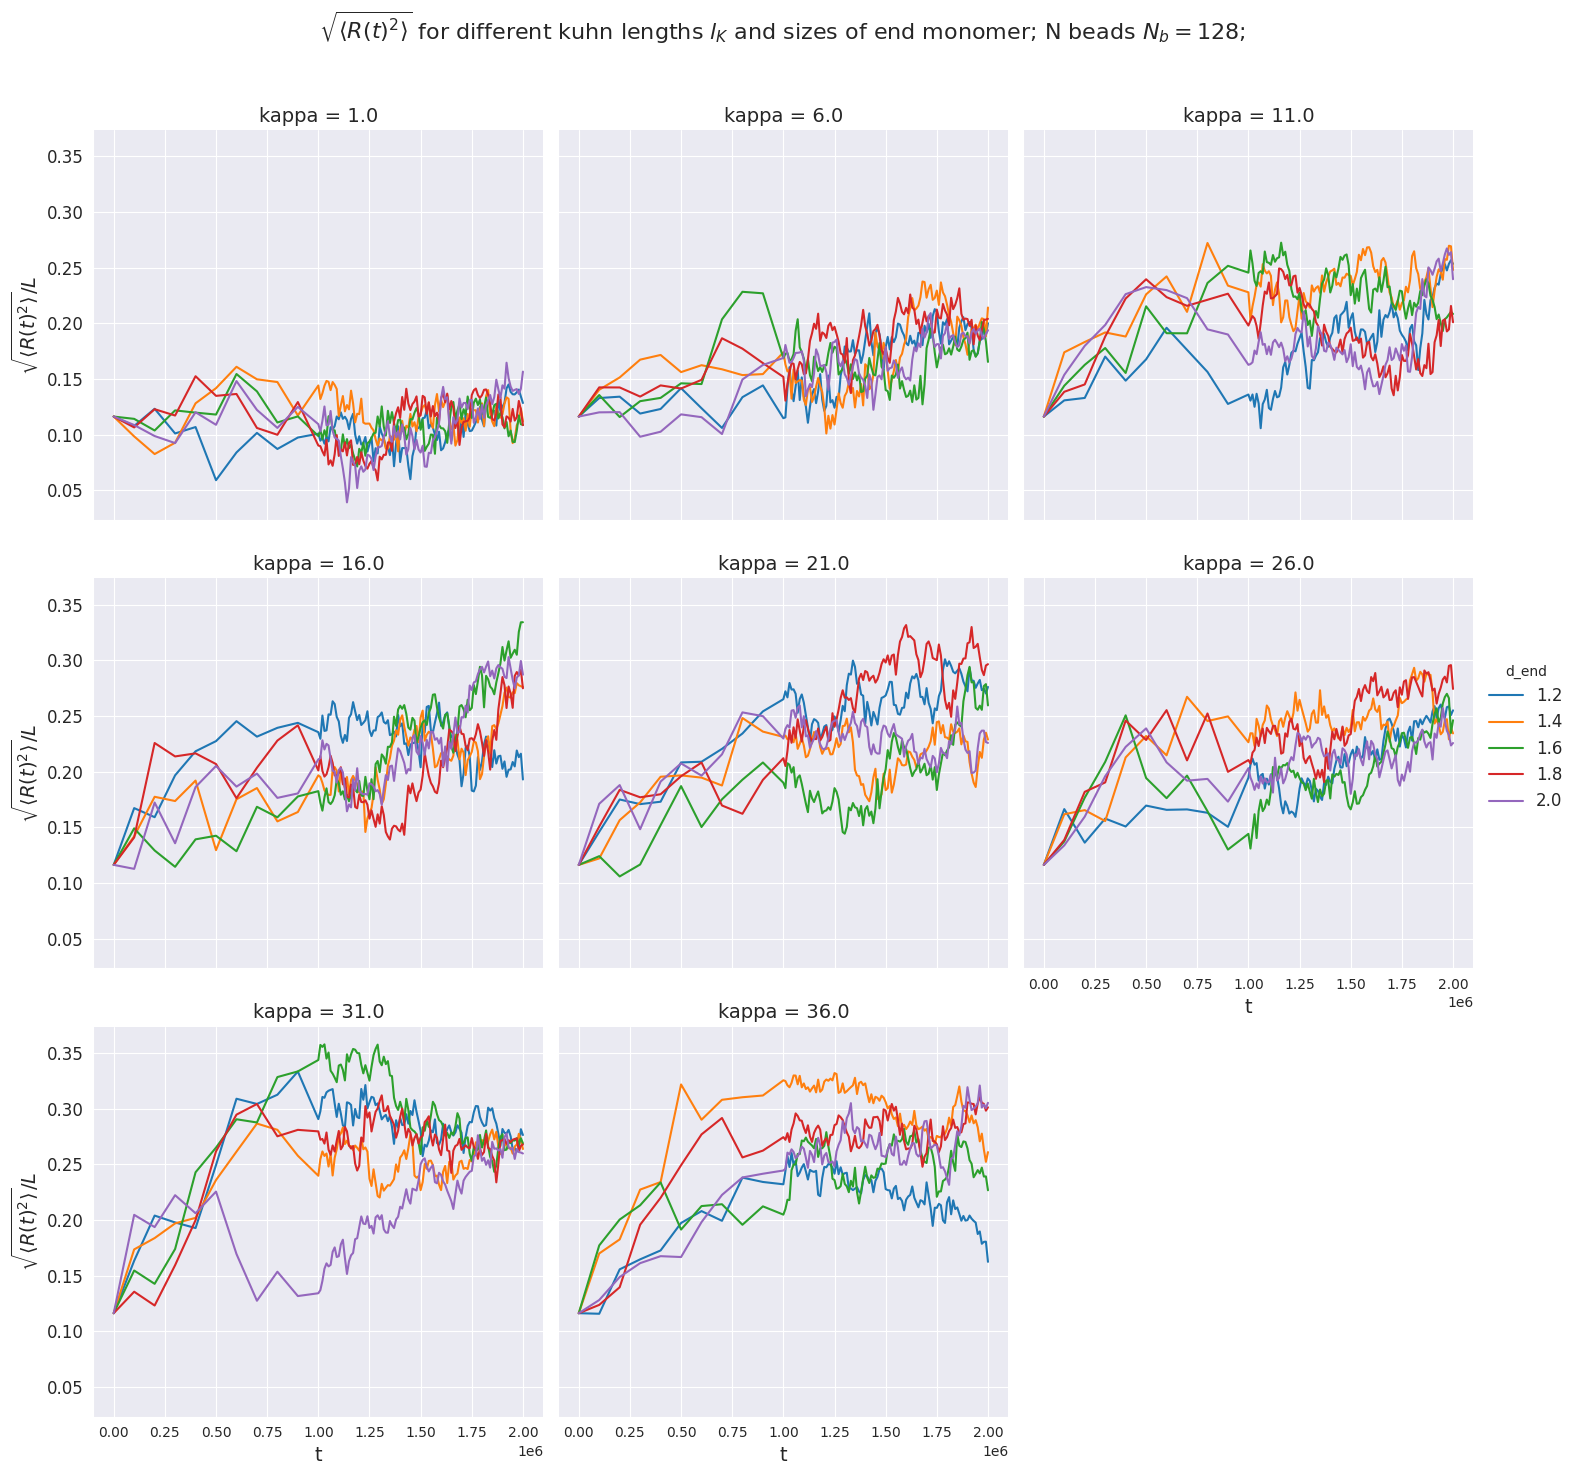

In [50]:
def plot_R(df_ete_mean: pd.DataFrame, d_end_colors) -> sns.FacetGrid:
    df = df_ete_mean.copy()
    col_name="$\sqrt{{\\langle R(t)^2 \\rangle }} / L$"
    df[col_name] = np.sqrt(df["R^2"]) / L_src
    g = sns.FacetGrid(df.reset_index(), col="kappa", col_wrap=3, hue="d_end", sharey=True, sharex=True, palette=d_end_colors, legend_out=True, height=5)
    g.map(sns.lineplot, "t", col_name)
    g.figure.subplots_adjust(top=0.9)
    g.figure.suptitle(
        f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$ and sizes of end monomer; '
        f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;'
    )
    g.add_legend()
    return g


d_end_colors = sns.color_palette(n_colors=len(d_ends))
kappa_colors = sns.color_palette(n_colors=len(kappas))

plot_R(df_ete_mean, d_end_colors)
plt.show()

## Equilibrium statistics

In [18]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

15000000

In [19]:
df_trajectory_unfolded_equi = df_trajectory_unfolded_kappas_d_ends.loc[df_trajectory_unfolded_kappas_d_ends["t"] > t_equilibrium]
df_trajectory_unfolded_equi

,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa,d_end
194560,15010000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0,5
194561,15010000,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1,1.0,5
194562,15010000,3,2,0.194592,-0.509555,-1.701060,0,0,0,1,1.0,5
194563,15010000,4,2,0.813384,-0.188361,-2.394560,0,0,0,1,1.0,5
194564,15010000,5,2,0.553176,-1.081360,-2.099160,0,0,0,1,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
17694715,25000000,1276,2,-4.221270,5.888230,27.949300,0,0,0,20,6.1,15
17694716,25000000,1277,2,-3.975800,5.646640,28.779800,0,0,0,20,6.1,15
17694717,25000000,1278,2,-3.918900,5.441910,29.751500,0,0,0,20,6.1,15
17694718,25000000,1279,2,-3.112300,4.901930,29.992500,0,0,0,20,6.1,15


In [53]:
df_ete_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_equi

R_x       R_y       R_z          R  \
kappa d_end molecule-ID t                                                  
1.0   1.2   1           1000000 -0.870683  14.16120 -4.131960  14.777374   
                        1010000  1.051970   7.96739  0.613874   8.059949   
                        1020000 -1.003450  10.09510 -1.954870  10.331480   
                        1030000  2.000600   9.51666  1.972450   9.922690   
                        1040000  6.824480   3.99521  4.800400   9.250896   
...                                   ...       ...       ...        ...   
36.0  2.0   4           1960000 -9.593660  10.32960 -6.070200  15.348820   
                        1970000 -8.739560   9.50169 -4.936400  13.821363   
                        1980000 -1.838220  12.70480 -4.565360  13.624739   
                        1990000 -2.635800  11.00090 -3.797850  11.932766   
                        2000000  1.898920   8.97820 -7.729220  11.998117   

                                   t/LJ         R^2  
kappa d_end molecule-ID t                            
1.0   1.2   1           1000000  2500.0  218.370768  
                        1010000  2525.0   64.962786  
                        1020000  2550.0  106.739473  
                        1030000  2575.0   98.459777  
                        1040000  2600.0   85.579070  
...                                 ...         ...  
36.0  2.0   4           1960000  4900.0  235.586276  
                        1970000  4925.0  191.030067  
                        1980000  4950.0  185.633508  
                        1990000  4975.0  142.390907  
                        2000000  5000.0  143.954814  

[16160 rows x 6 columns]

In [54]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa d_end t                              
1.0   1.2   1010000   135.866468   1.854017
            1020000   143.531319   1.854017
            1030000   128.186721   1.854017
            1040000   147.655155   1.854017
            1050000   134.134830   1.854017
...                          ...        ...
36.0  2.0   1960000  1560.974605  68.870000
            1970000  1374.675231  68.870000
            1980000  1398.289199  68.870000
            1990000  1369.986720  68.870000
            2000000  1413.417286  68.870000

[4000 rows x 2 columns]

### Mean bond length

In [33]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [34]:
L_contour = l_b*(conf.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

### Kuhn lengths

Svaneborg (8)

In [35]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695,  4.39955514,  7.57733934, 10.86472632])

In [ ]:
l_ks / L_contour

Estimate from fit (Worm-like chain model, Hinczewski):

In [ ]:
PATH_DF_LK_ESTIMATE = PATH_DATA_PROCESSED / "l_K-estimate.csv"

if PATH_DF_LK_ESTIMATE.exists():
    l_ks_estimate = pd.read_csv(PATH_DF_LK_ESTIMATE, index_col=["kappa", "d_end"])
else:
    l_ks_estimate = transform.estimate_kuhn_length_df(
        df_trajectory_unfolded_equi,
        group_by_params=["kappa", "d_end"]
    )
    l_ks_estimate.to_csv(PATH_DF_LK_ESTIMATE, index=True)

l_ks_estimate

In [61]:
l_ks_estimate / L_contour

array([0.01505006, 0.08662114, 0.16535433, 0.24409449, 0.32283465,
       0.4015748 , 0.48031496, 0.55905512])

Absolute difference of analytical l_K and estimated l_K relative to analytical l_K

In [ ]:
np.abs(l_ks - l_ks_estimate["l_K"]) / l_ks

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [62]:
N_Ks = (L_contour / l_ks)
N_Ks

array([66.44491561, 11.54452591,  6.04761901,  4.09677419,  3.09756098,
        2.49019608,  2.08196721,  1.78873239])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [65]:
df_ete_sq_t_mean_kappas_dend = transform.calculate_ete_sq_t_avg_df_kappas_dend(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas_dend

R^2
kappa d_end             
1.0   1.2     174.985922
      1.4     209.136097
      1.6     177.765111
      1.8     184.900698
      2.0     180.877305
6.0   1.2     463.747083
      1.4     465.922873
      1.6     413.802340
      1.8     561.698661
      2.0     441.369840
11.0  1.2     538.594606
      1.4     849.350204
      1.6     812.971595
      1.8     565.990470
      2.0     540.437853
16.0  1.2     808.259123
      1.4     726.008887
      1.6     891.695697
      1.8     654.158976
      2.0     829.810683
21.0  1.2    1080.891579
      1.4     714.947376
      1.6     638.523241
      1.8    1186.296408
      2.0     801.716408
26.0  1.2     698.937906
      1.4     957.166642
      1.6     641.172990
      1.8     958.111304
      2.0     695.744082
31.0  1.2    1270.820709
      1.4     985.951637
      1.6    1388.968475
      1.8    1134.196056
      2.0     753.256715
36.0  1.2     772.545945
      1.4    1393.759552
      1.6     963.497309
      1.8    1209.173487
      2.0    1110.159295

### Summarize statistics by kappas and d_end

In [67]:
df_kuhn_summary = df_ete_sq_t_mean_kappas_dend.copy()
df_kuhn_summary["l_K"] = kremer_grest.bare_kuhn_length(df_kuhn_summary.index.get_level_values("kappa").to_numpy(), l_b)
df_kuhn_summary["N_K"] = L_contour / df_kuhn_summary["l_K"]
df_kuhn_summary

R^2        l_K        N_K
kappa d_end                                   
1.0   1.2     174.985922   1.854017  66.444916
      1.4     209.136097   1.854017  66.444916
      1.6     177.765111   1.854017  66.444916
      1.8     184.900698   1.854017  66.444916
      2.0     180.877305   1.854017  66.444916
6.0   1.2     463.747083  10.670858  11.544526
      1.4     465.922873  10.670858  11.544526
      1.6     413.802340  10.670858  11.544526
      1.8     561.698661  10.670858  11.544526
      2.0     441.369840  10.670858  11.544526
11.0  1.2     538.594606  20.370000   6.047619
      1.4     849.350204  20.370000   6.047619
      1.6     812.971595  20.370000   6.047619
      1.8     565.990470  20.370000   6.047619
      2.0     540.437853  20.370000   6.047619
16.0  1.2     808.259123  30.070000   4.096774
      1.4     726.008887  30.070000   4.096774
      1.6     891.695697  30.070000   4.096774
      1.8     654.158976  30.070000   4.096774
      2.0     829.810683  30.070000   4.096774
21.0  1.2    1080.891579  39.770000   3.097561
      1.4     714.947376  39.770000   3.097561
      1.6     638.523241  39.770000   3.097561
      1.8    1186.296408  39.770000   3.097561
      2.0     801.716408  39.770000   3.097561
26.0  1.2     698.937906  49.470000   2.490196
      1.4     957.166642  49.470000   2.490196
      1.6     641.172990  49.470000   2.490196
      1.8     958.111304  49.470000   2.490196
      2.0     695.744082  49.470000   2.490196
31.0  1.2    1270.820709  59.170000   2.081967
      1.4     985.951637  59.170000   2.081967
      1.6    1388.968475  59.170000   2.081967
      1.8    1134.196056  59.170000   2.081967
      2.0     753.256715  59.170000   2.081967
36.0  1.2     772.545945  68.870000   1.788732
      1.4    1393.759552  68.870000   1.788732
      1.6     963.497309  68.870000   1.788732
      1.8    1209.173487  68.870000   1.788732
      2.0    1110.159295  68.870000   1.788732

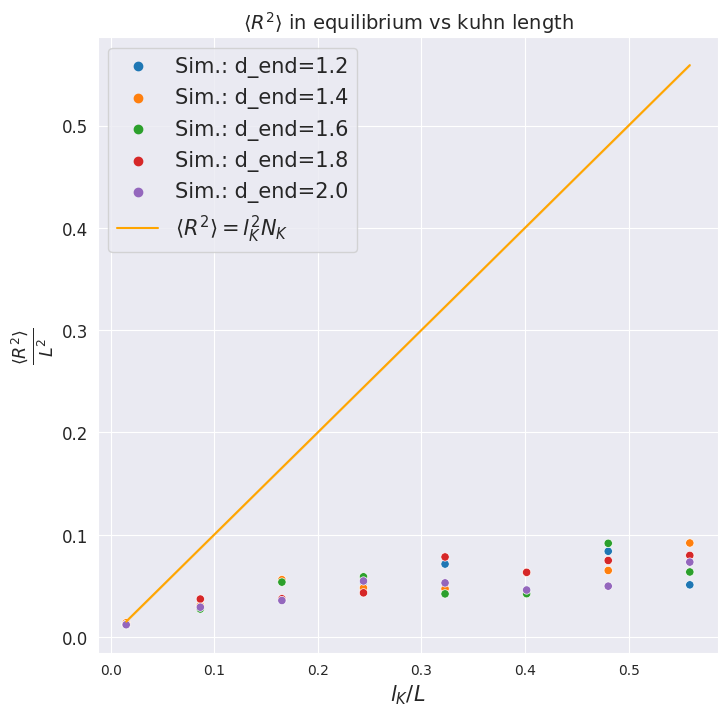

In [86]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=df_kuhn_summary["R^2"]/L_contour**2,
    ax=ax,
    hue=df_kuhn_summary.index.get_level_values("d_end"),
    palette=d_end_colors,
)

sns.lineplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=(df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"]) / L_contour**2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange",
    legend=False
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, [f"Sim.: d_end={d}" for d in labels[:5]]+labels[5:], fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [87]:
df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa  d_end
1.0    1.2       1.305227
       1.4       1.092094
       1.6       1.284821
       1.8       1.235238
       2.0       1.262714
6.0    1.2       2.834612
       1.4       2.821375
       1.6       3.176741
       1.8       2.340299
       2.0       2.978325
11.0   1.2       4.659126
       1.4       2.954471
       1.6       3.086676
       1.8       4.433609
       2.0       4.643236
16.0   1.2       4.583089
       1.4       5.102311
       1.6       4.154246
       1.8       5.662726
       2.0       4.464058
21.0   1.2       4.532616
       1.4       6.852625
       1.6       7.672808
       1.8       4.129884
       2.0       6.110972
26.0   1.2       8.719243
       1.4       6.366926
       1.6       9.504782
       1.8       6.360649
       2.0       8.759269
31.0   1.2       5.735783
       1.4       7.393012
       1.6       5.247889
       1.8       6.426713
       2.0       9.676850
36.0   1.2      10.981994
       1.4       6.087202
       1.6       8.805520

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [88]:
df_ete_change_equi = transform.calculate_ens_avg_df_ete_change_kappas_dend(df_ete_equi)
df_ete_change_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_equi["kappa"], l_b=l_b)
df_ete_change_equi

,dR^2,kappa,d_end,l_K
t,,,,
1000000,0.000000,1.0,1.2,1.854017
1010000,27.574960,1.0,1.2,1.854017
1020000,13.127311,1.0,1.2,1.854017
1030000,39.323045,1.0,1.2,1.854017
1040000,81.062539,1.0,1.2,1.854017
...,...,...,...,...
1960000,442.857368,36.0,2.0,68.870000
1970000,447.345530,36.0,2.0,68.870000
1980000,453.003020,36.0,2.0,68.870000


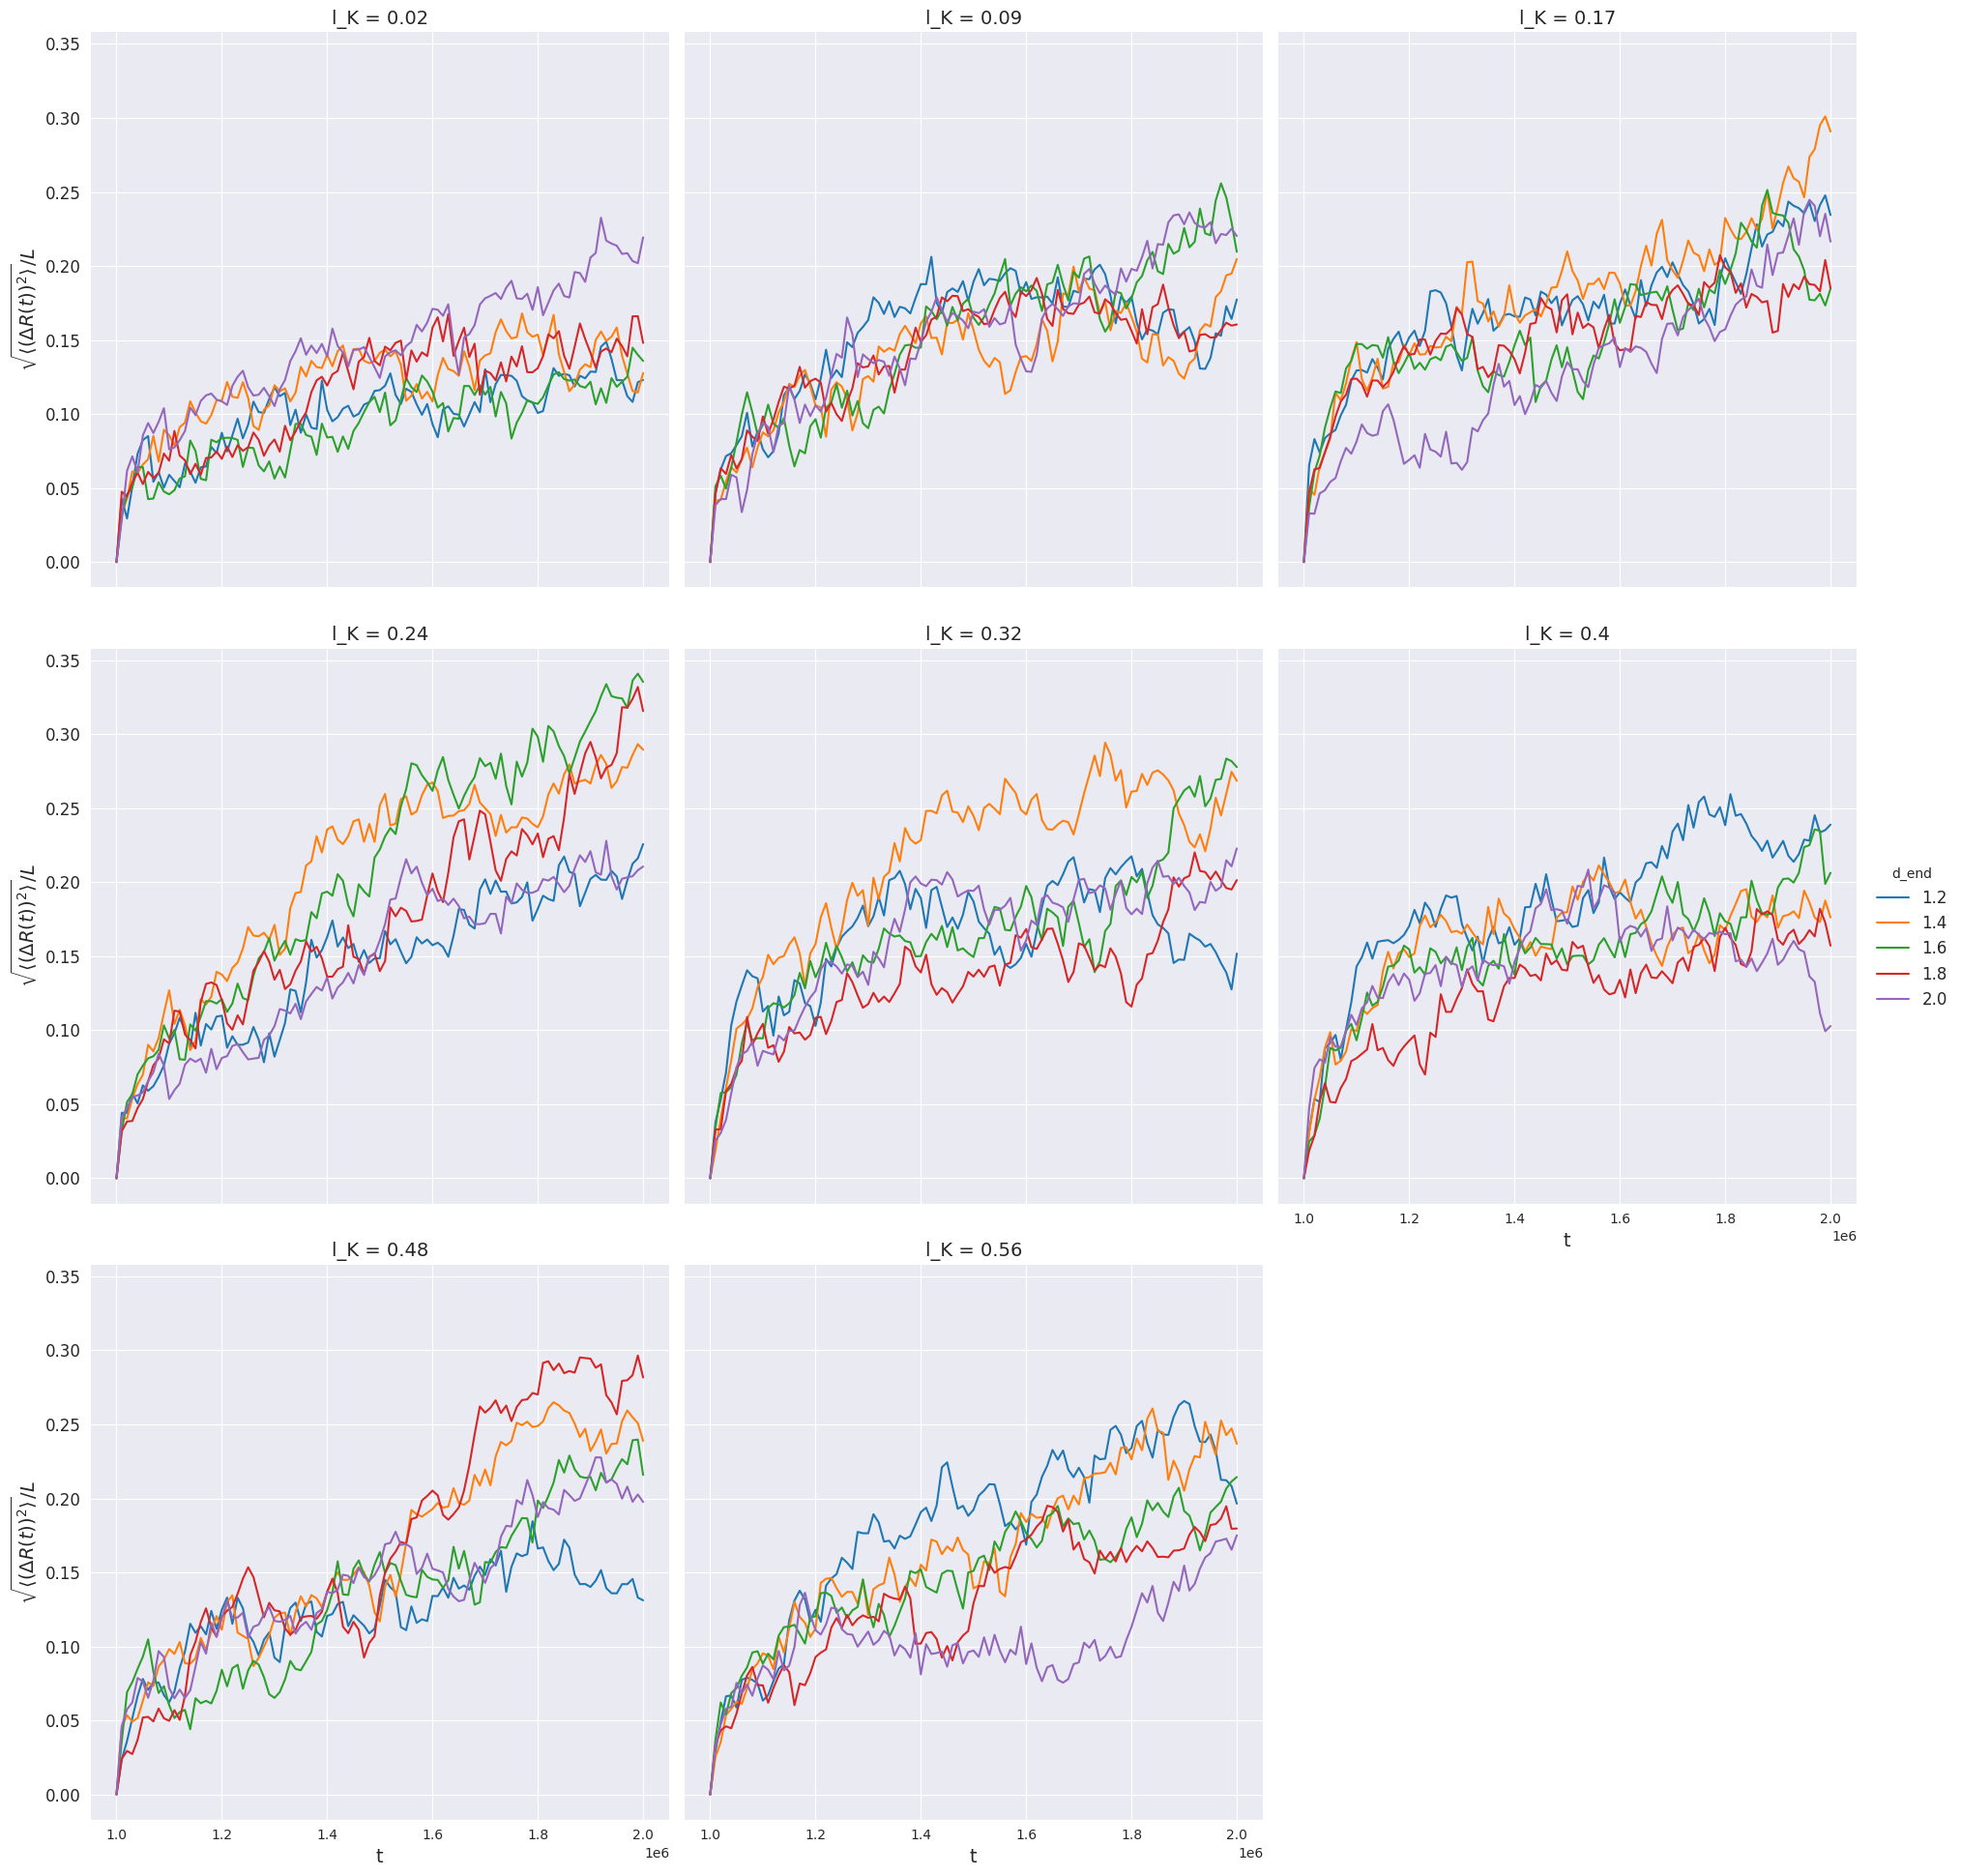

In [98]:
def plot_raw_dR():
    df = df_ete_change_equi.copy()
    df["l_K"] = (df["l_K"]/L_contour).round(2).astype("category")
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour

    g = sns.FacetGrid(
        df.reset_index(),
        col="l_K",
        col_wrap=3,
        hue="d_end",
        palette=d_end_colors,
        height=6.5
    )

    g.map(
        sns.lineplot,
        "t",
        dR_col,
    )

    g.add_legend()

plot_raw_dR()